## TPU  (Tensor Processing Unit-Tensor İşlem Birimi) üzerinde MNIST veri seti eğitimi<br>
<table><tr><td><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/keras-tensorflow-tpu300px.png" width="300" alt="Keras+Tensorflow+Cloud TPU"></td></tr></table>


Bu örnek bir Keras modelini kullanarak bir GPU veya TPU kullanarak "MNIST" el yazısı rakamları tanıma modelini eğitiyor. Veriler tf.data.Dataset API kullanılarak işlenmektedir. Bu eğitim amaçlı sağlanan çok basit bir örnek.
MNIST kadar küçük bir veri setinde olağanüstü TPU performansı beklemeyin. Ama büyük bir veri setinde GPU ile arasında büyük fark oluşacağını görebilirsiniz.

### DETAYLI TPU KULLANIMI ANLATIMI VE FARKLI ÖRNEKLER İÇİN: [Adım Adım Google Colab Ücretsiz TPU Kullanımı](https://medium.com/deep-learning-turkiye/ad%C4%B1m-ad%C4%B1m-google-colab-%C3%BCcretsiz-tpu-kullan%C4%B1m%C4%B1-621dc6e5487d)


<h3><a href="https://cloud.google.com/gpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/gpu-hexagon.png" width="50"></a>  &nbsp;&nbsp; GPU veya TPU kullanarak Eğitim&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

  1. GPU ya da TPU seçeneğini işaretleyin (Runtime > Change runtime type) 
  1. Runtime > Run All (Dikkat: the "Colab-only auth" hücre kullanıcı girişi gerektirir.)
  
### Modeli Deploy Etmek
Bu komut satırı arayüzünü kullanır. Aynı şeyi adresindeki ML Engine UI üzerinden de yapabilirsiniz: https://console.cloud.google.com/mlengine/models

Ya ya .h5 model dosyasını .json olarak indirip flask ile heroku da deployedebilirsiniz.

**Bunun için kaynak yazı:  [Apache Web Sunucusunda Python Flask Web Uygulaması Nasıl Çalıştırılır](http://blog.yavuzz.com/post/apache-web-sunucusunda-python-flask-web-uygulamasi-nasil-calistirilir)**


**KAYNAK: ** [Martin Gorner](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb#scrollTo=hleIN5-pcr0N)

**Son güncelleme: 08.08.2019**

### Import EDİLMESİ GEREKENLER

In [0]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.14.0


In [0]:
#@title Görselleştirme Araçları [BURAYI ÇALIŞTIR]
"""
Bu hücre yalnızca görselleştirme ve indirme işlemleri için kullanılan yardımcı fonksiyonları içerir.
Okumayı atlayabilirsiniz.
Burada çok az yararlı Keras / Tensorflow kodu var.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# Veri kümelerinden bir parti çekin. Bu kod çok hoş değil. mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # Herbirinden bir batch almak: 10000 doğrulama verisi, N eğitim verisi
  unbatched_train_ds = training_dataset.apply(tf.data.experimental.unbatch())
  v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
  t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
  
  # Birkez çalıştır, bir batch-küme al. Session.run sonuçlar numpy sonuçlar
  with tf.Session() as ses:
    (validation_digits, validation_labels,
     training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # Verisetindeki one-hot encoding
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# cTest için yerel fontlardan rakamlar oluşturun
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# tahminleri ile birlikte bir rakam hanesini görüntülemek için yardımcı
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # kırmızı kötü tahminler
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# Tanınmayan / tanınan duruma göre sıralanmış, birden çok basamaklı satır görüntülemek için yardımcı program.
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: önce tanınmayan
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# Eğitim ve doğrulama eğrilerinin görüntülenmesi için yardımcı program
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # ilk aramada alt noktaları ayarla
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### TPU Kullanılabilmesi için Colab Kimlik Doğrulama İşlemleri 

In [0]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # bu her zaman Colab'da olacak, GPU'ya göre 0 ya da 1 seçilmiş olacak.
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Özel GCS kovalarınıza erişebilmeleri için kimlik bilgilerinizi kullanarak 
  #Colab makinesini ve ayrıca TPU'yu doğrular.
  auth.authenticate_user()

W0806 14:41:48.895899 140438570100608 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### TPU ya da GPU Tanımlama

In [0]:
# Donanım Tanı
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU tanı
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Uygun dağıtım stratejisini seçin
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) #TPU ile sunucu arasında ileri geri gitmek pahalıdır. Rapor vermeden önce TPU'da 128 parti çalıştırmak daha iyidir.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # CPU ve tek GPU'da çalışan varsayılan strateji
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # CPU ve tek GPU'da çalışan varsayılan strateji
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.97.115.234:8470']
Number of accelerators:  8


### PARAMETRELER

In [0]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size (küme boyutu).
# Global küme büyüklüğü otomatik olarak herkes tarafından paylaşılacaktır.
# tf.data.Dataset API'sinin kopyaları. Tek bir TPU 8 çekirdeğe sahiptir.
# En iyi uygulama, parti büyüklüğünün kopya sayısı (çekirdek) sayısına göre ölçeklendirilmesidir. 
#Öğrenme hızı da arttırılmalıdır.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Öğrenme hızı daha sonra LEARNING_RATE * LEARNING_RATE_EXP_DECAY ** dönemi olarak hesaplandı
# 0.6 yerine 0.7 bozunma daha yavaş bozunma anlamına gelir; daha hızlı bir öğrenme oranı.

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### tf.data.Dataset: dosyaları ayrıştırın ve eğitim ve doğrulama veri kümelerini hazırlayın
Lütfen okuyun: [best practices for building](https://www.tensorflow.org/guide/performance/datasets) 

In [0]:
def read_label(tf_bytestring):
    label = tf.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # Bu küçük veri kümesi RAM'de tamamen önbellekte saklanabilir, TPU için bu kadar küçük bir veri setinden iyi performans almak önemlidir.
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Şimdilik Keras için zorunlu
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder TPU'da önemlidir, küme büyüklüğü sabitlenmelidir
    dataset = dataset.prefetch(10)  # Geçerli olanı çalıştırırken sonraki ükümeleri getir
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # Bu küçük veri kümesi RAM'de tamamen önbellekte saklanabilir, TPU için bu kadar küçük bir veri setinden iyi performans almak önemlidir.
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 doğrulama kümesi, tamamı bir küme içinde
    dataset = dataset.repeat() # Şimdilik Keras için zorunlu
    return dataset

# veri kümelerini başlat
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# TPU için veri setini döndüren bir işleve ihtiyacımız olacak
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Verilere bir göz atalım! 

W0806 14:42:18.038807 140438570100608 deprecation.py:323] From <ipython-input-4-3aa8720219ec>:22: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


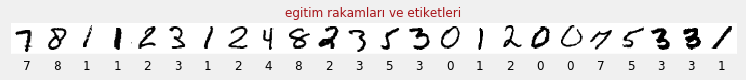

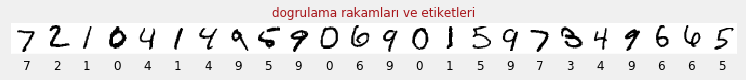

In [0]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "egitim rakamları ve etiketleri", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "dogrulama rakamları ve etiketleri", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 Evrişim Katmanı, 2 tam/tüm Bağlantı Katmanı
Çapraz entropi, unutma, softmax veya toplu normalizasyonun ne anlama geldiğinden emin değilseniz, bu kaynaklara göz atabilirsiniz:


*  [Yapay Öğrenme Modelleri Geliştirirken Karşılaşılan Sorunlar & Çözümleri (Part1)](https://www.youtube.com/watch?v=gbzwtZGrkrQ)
*   [Yapay Öğrenme Modelleri Geliştirirken Karşılaşılan Sorunlar & Çözümleri (Part2)](https://www.youtube.com/watch?v=L3NJi7diDmg&t=139s)
* [Derin Öğrenme Uygulamalarında Başarım İyileştirme Yöntemleri (Regularization)](https://medium.com/@necmettin.carkaci/derin-%C3%B6%C4%9Frenme-uygulamalar%C4%B1nda-ba%C5%9Far%C4%B1m-i%CC%87yile%C5%9Ftirme-y%C3%B6ntemleri-regularization-fb521e64c30f)
* [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [0]:
# Bu model 10 epoch % 99.4, bazen % 99.5'e kadar doğruluk sağlar (küme büyüklüğü 64 ile)
  

def make_model():
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # batch norm önce bias a ihtiyaç yoktur
        tf.keras.layers.BatchNormalization(scale=False, center=True), # "relu" dan önce batch normu scale etmeye gerek yoktur
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # dense katmanında sadece dropout uygulanır

        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # LearningRateScheduler öğrenme oranı belirler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
with strategy.scope():
    model = make_model()

# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (Reshape)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 12)        36        
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 24)       

### EĞİTİM VE DOĞRULAMA İŞLEMLERİ

In [0]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 veri kümesindeki veri miktarı
print("Steps per epoch: ", steps_per_epoch)
  
#Little wrinkle: Tensorfow'un (1.14) şu anki sürümünde, eğitim ve değerlendirme arasında 
#TPU geçişi yavaştır (yaklaşık 10 sn). Küçük modeller için, sonunda tek bir 
#değerlendirme yapılması tavsiye edilir.
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    callbacks=[lr_decay])

final_stats = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", final_stats[1])

Steps per epoch:  117


W0806 14:44:02.229157 140438570100608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_distributed.py:411: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.



Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
117/117 [==============================] - 5s 42ms/step - loss: 0.0396 - acc: 0.9501

Epoch 00002: LearningRateScheduler reducing learning rate to 0.006999999999999999.
Epoch 2/10
117/117 [==============================] - 1s 9ms/step - loss: 0.0175 - acc: 0.9847

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0049.
Epoch 3/10
117/117 [==============================] - 1s 9ms/step - loss: 0.0146 - acc: 0.9901

Epoch 00004: LearningRateScheduler reducing learning rate to 0.003429999999999999.
Epoch 4/10
117/117 [==============================] - 1s 9ms/step - loss: 0.0120 - acc: 0.9925

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0024009999999999995.
Epoch 5/10
117/117 [==============================] - 1s 9ms/step - loss: 0.0035 - acc: 0.9948

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0016806999999999994.
Epoch 6/10
117/117 [============================

### Kestirimleri Görselleştirin

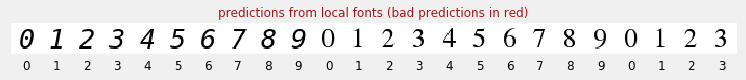

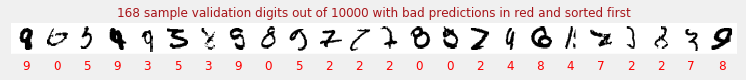

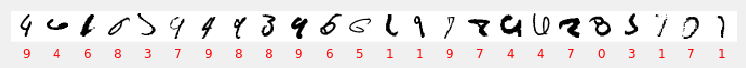

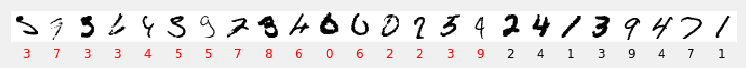

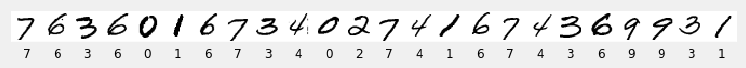

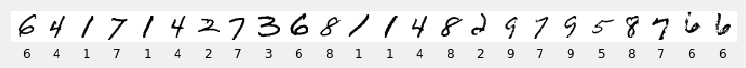

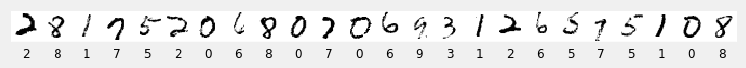

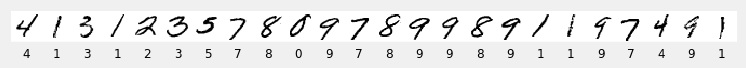

In [0]:
# el yazısı rakamları tanıma
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# geçerleme verisini tanıma
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Modeli Deploy Etmek
Bu komut satırı arayüzünü kullanır. Aynı şeyi adresindeki ML Engine UI üzerinden de yapabilirsiniz: https://console.cloud.google.com/mlengine/models

Ya  ya .h5 model dosyasını .json olarak indirip flask ile heroku da deployedebilirsiniz. 

**Bunun için kaynak yazı: [Apache Web Sunucusunda Python Flask Web Uygulaması Nasıl Çalıştırılır](http://blog.yavuzz.com/post/apache-web-sunucusunda-python-flask-web-uygulamasi-nasil-calistirilir)**

**Model JSON olarak kaydetmek için:**

```
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
```

    
**Model ağırlıklarını HDF5 olarak kaydetmek için:**

```
model.save_weights("model.h5")
print("Saved model to disk")
```

 
**.json olarak yüklemek ve modeli oluşturmak için:**
```
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
```

**Ağırlıkları yeni modele yüklemek için:**
```
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
```

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


Bu resmi bir Google ürünü değil, eğitim amaçlı verilen örnek koddur.
